In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.models import *
from src.data_generation import *

Create environment

(-1.87387462510129,
 3.4866397559402817,
 -1.3073475487092456,
 2.3311749941735544)

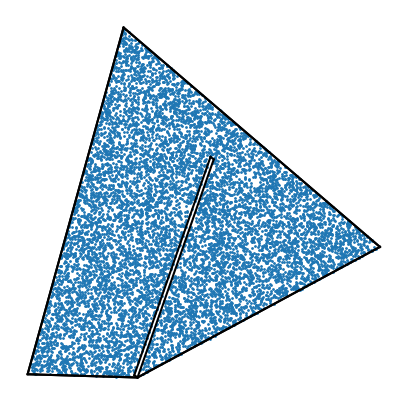

In [2]:
# Create environment
env = PolygonEnvironment()

# Generate random samples
samples = env.generate_random_samples(n_samples=10000)

# Plot
fig, ax = env.plot_env()
ax.scatter(samples[:,0], samples[:,1], s=1)
ax.axis('off')

Train model

In [3]:
train_steps = 5000      # number of training steps
scale = 0.1             # scale of the correlation function
n_in = 2                # no. of input dimensions
n_out = 100             # no. of spatial representations
bs = 512                # batch size
lr = 1e-3               # learning rate

# Create model and optimizer
model = OldSpaceNet(n_in, n_out, scale=scale)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Reset gradients
    optimizer.zero_grad()

    # Generate batch of random samples
    r = env.generate_random_samples(bs)

    # Get predictions
    corr = model(r)

    # Compute distance
    d = torch.sum((r[:,None] - r[None])**2, dim=-1)

    # Compute loss
    correlation_loss = (corr - torch.exp((-0.5 / (scale**2)) * d))**2
    loss = torch.mean(correlation_loss)

    # Backpropagate
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        loss = loss.item()
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.005342: 100%|██████████| 5000/5000 [06:30<00:00, 12.80it/s]


### Evaluate model on all positions in the environment

In [23]:
# Sample points
nx, ny = 0.05, 0.05
nx, ny = 64, 64
x = np.linspace(env.polygon.bounds[0], env.polygon.bounds[2], nx)
y = np.linspace(env.polygon.bounds[1], env.polygon.bounds[3], ny)
xx, yy = np.meshgrid(x,y)
u = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype('float32')

# Output of last layer
p = model.spatial_representation(torch.tensor(u))

# Convert to numpy arrays
p = p.detach().numpy()
# pcorr = pcorr.detach().numpy()

Text(0, 0.5, 'Train Loss')

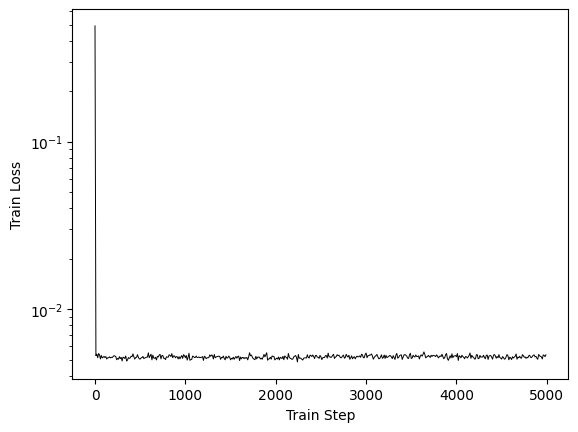

In [24]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

### Create a mask indicating whether a position is in the environment

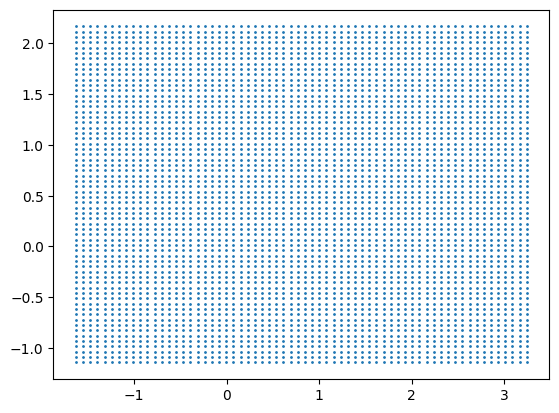

In [25]:
plt.scatter(u[:,0], u[:,1], s=1)

In [26]:
# Get mask of positions that are in or out of the environment
pos_mask = np.ones(u.shape[0], dtype=bool)
for i, _p in enumerate(u):
    if not env.polygon.contains(Point(_p)):
        pos_mask[i] = False
pos_mask = pos_mask.reshape(x.shape[0], y.shape[0])

### Find the maximum activation for each unit

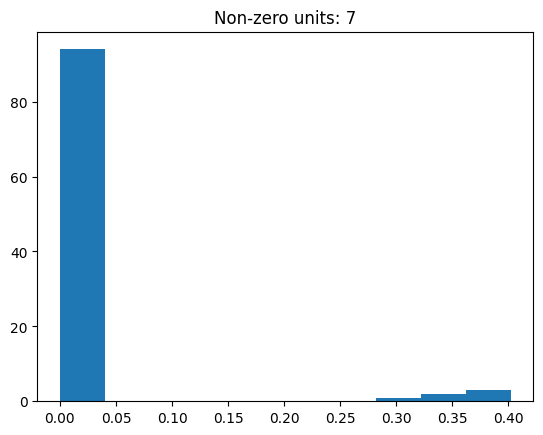

In [27]:
# select units nonzero activity
max_ind = np.argmax(p, axis = 0)
max_loc = u[max_ind]
mask = np.array([p[ind, i] > 0 for i, ind in enumerate(max_ind)])
nonzero_max_loc = max_loc[mask]

plt.hist(np.amax(p, axis = 0))
plt.title(f"Non-zero units: {mask.sum()}")
plt.show()

### Plot the spatial representations

#### Output layer

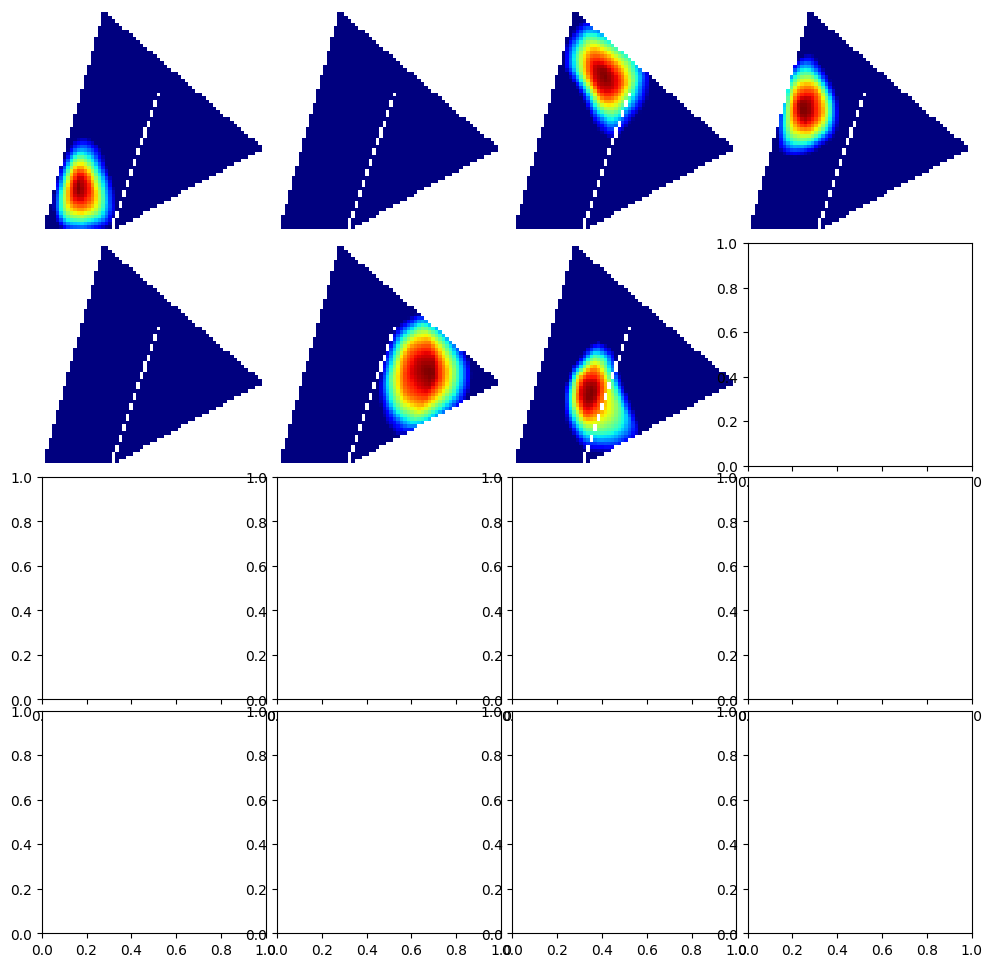

In [29]:
n_p = 4
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[mask][:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(x.shape[0], y.shape[0])
    representation[~pos_mask] = np.nan

    ax[row, col].imshow(representation, cmap="jet", origin="lower")

plt.subplots_adjust(wspace=0.05, hspace=0.05)

### Peak distribution

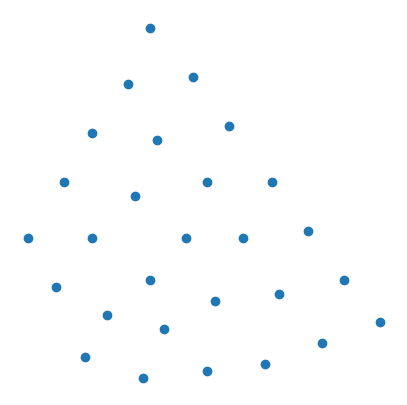

In [33]:
peaks = []
for i, representation in enumerate(p.T[mask]):

    representation = representation.reshape(nx, ny)
    representation[~pos_mask] = np.nan

    peaks.append(np.unravel_index(np.nanargmax(representation), representation.shape))

peaks = np.array(peaks)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(peaks[:, 0], peaks[:, 1])
ax.axis('off')
plt.show()

#### Hidden layer

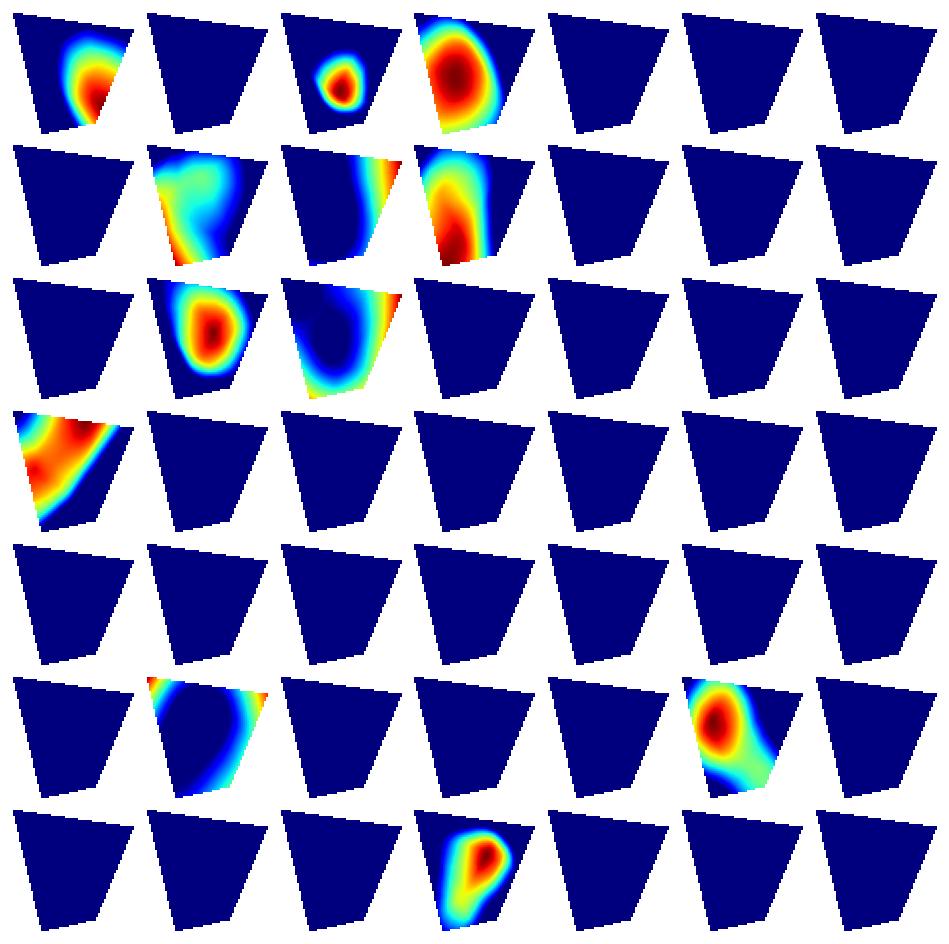

In [9]:
n_p = 7
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(hidden_p.T[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(nx, ny)
    representation[~pos_mask] = np.nan

    ax[row, col].imshow(representation, cmap = "jet")

plt.subplots_adjust(wspace=0.05, hspace=0.05)